code from https://pytorch.org/docs/stable/func.whirlwind_tour.html

In [26]:
import torch
from torch import nn
from torch.func import vjp, jvp, grad, vmap, hessian

# Pytorch - Computational Graph and Backpropagation

- Pytorch operators build a computational graph under the hood
- each operator defines a forward operation (the function application), and a backward (the gradient computation). During the forward, any information required by the backward is stored (e.g. activations).
- The computational graph is used to compute the gradient
- after the backward, every input tensors (the roots of the graph) contains its gradient w.r.t. the output
- nn.Modules contain multiple tensors (their parameters) and use them to compute their outputs (forward pass)

In [27]:
W = nn.Linear(8, 16)
x = torch.randn(1, 8)

assert W.weight.grad is None

y = W(x).sum()
y.backward()

print(W.weight.grad)

tensor([[ 1.4348,  0.4422, -1.0338, -2.0159,  1.4705, -0.3993,  0.4673,  1.9141],
        [ 1.4348,  0.4422, -1.0338, -2.0159,  1.4705, -0.3993,  0.4673,  1.9141],
        [ 1.4348,  0.4422, -1.0338, -2.0159,  1.4705, -0.3993,  0.4673,  1.9141],
        [ 1.4348,  0.4422, -1.0338, -2.0159,  1.4705, -0.3993,  0.4673,  1.9141],
        [ 1.4348,  0.4422, -1.0338, -2.0159,  1.4705, -0.3993,  0.4673,  1.9141],
        [ 1.4348,  0.4422, -1.0338, -2.0159,  1.4705, -0.3993,  0.4673,  1.9141],
        [ 1.4348,  0.4422, -1.0338, -2.0159,  1.4705, -0.3993,  0.4673,  1.9141],
        [ 1.4348,  0.4422, -1.0338, -2.0159,  1.4705, -0.3993,  0.4673,  1.9141],
        [ 1.4348,  0.4422, -1.0338, -2.0159,  1.4705, -0.3993,  0.4673,  1.9141],
        [ 1.4348,  0.4422, -1.0338, -2.0159,  1.4705, -0.3993,  0.4673,  1.9141],
        [ 1.4348,  0.4422, -1.0338, -2.0159,  1.4705, -0.3993,  0.4673,  1.9141],
        [ 1.4348,  0.4422, -1.0338, -2.0159,  1.4705, -0.3993,  0.4673,  1.9141],
        [ 1.4348

we can visualize the computational graph. We use torchviz, which traverses the computational graph and plots it.

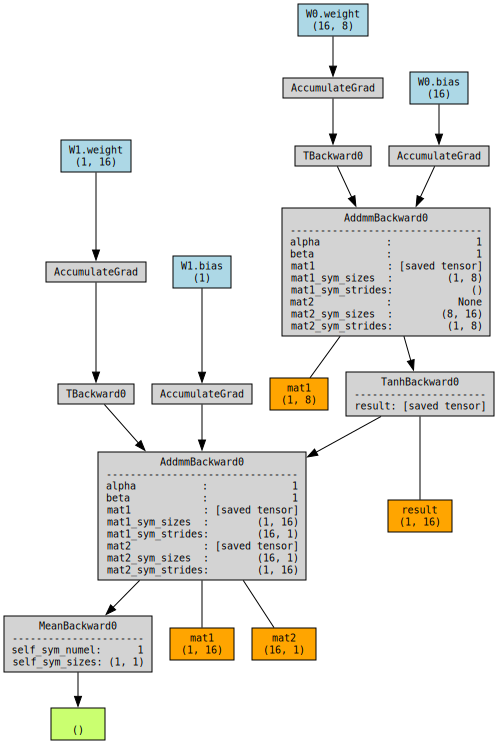

In [28]:
from torchviz import make_dot

model = nn.Sequential()
model.add_module('W0', nn.Linear(8, 16))
model.add_module('tanh', nn.Tanh())
model.add_module('W1', nn.Linear(16, 1))

x = torch.randn(1, 8)
y = model(x)

make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

# Controlling the Computational Graph

Sometimes you don't want to store the computational graph. It's expensive (mostly memory). Always use `no_grad` when you don't need gradients, such as during inference.

In [29]:
W = nn.Linear(8, 16)
x = torch.randn(1, 8)

assert W.weight.grad is None

with torch.no_grad():
    y = W(x).sum()
y.backward()  # this will fail because we disabled the creation of the computational graph

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

other times, you want to truncate the gradient at a certain point. For example, you can use it to freeze the first part of the network during finetuning

In [30]:
W1 = nn.Linear(8, 16)
W2 = nn.Linear(16, 16)

x = torch.randn(1, 8)

with torch.no_grad():
    h = W1(x)  # no computational graph for first layer
y = W2(h).sum()  # build computational graph. h is a root, so it will not be backpropagated into.

y.backward()

assert W1.weight.grad is None
W2.weight.grad

tensor([[ 1.2033, -0.1066,  0.3591, -0.1294, -0.9180, -0.3292,  0.2503, -0.0913,
         -0.4861, -0.2739, -0.3371, -0.8888, -0.3838, -0.1801, -0.8955,  1.0367],
        [ 1.2033, -0.1066,  0.3591, -0.1294, -0.9180, -0.3292,  0.2503, -0.0913,
         -0.4861, -0.2739, -0.3371, -0.8888, -0.3838, -0.1801, -0.8955,  1.0367],
        [ 1.2033, -0.1066,  0.3591, -0.1294, -0.9180, -0.3292,  0.2503, -0.0913,
         -0.4861, -0.2739, -0.3371, -0.8888, -0.3838, -0.1801, -0.8955,  1.0367],
        [ 1.2033, -0.1066,  0.3591, -0.1294, -0.9180, -0.3292,  0.2503, -0.0913,
         -0.4861, -0.2739, -0.3371, -0.8888, -0.3838, -0.1801, -0.8955,  1.0367],
        [ 1.2033, -0.1066,  0.3591, -0.1294, -0.9180, -0.3292,  0.2503, -0.0913,
         -0.4861, -0.2739, -0.3371, -0.8888, -0.3838, -0.1801, -0.8955,  1.0367],
        [ 1.2033, -0.1066,  0.3591, -0.1294, -0.9180, -0.3292,  0.2503, -0.0913,
         -0.4861, -0.2739, -0.3371, -0.8888, -0.3838, -0.1801, -0.8955,  1.0367],
        [ 1.2033, -0.1

If you want to disable the gradient only for some parameters, you can set `requires_grad = False`

In [31]:
W = nn.Linear(8, 16)
x = torch.randn(1, 8)
W.weight.requires_grad = False

y = W(x).sum()
y.backward()

assert W.weight.grad is None  # the gradient for the weight is not computed
W.bias.grad  # the gradient for the bias is still computed

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

If you already computed the output and you don't want to backpropagate, you can call `detach` on the output. This method will "detach" the value from its computational graph, returning a new tensor.

In [32]:
W1 = nn.Linear(8, 16)
W2 = nn.Linear(16, 16)

x = torch.randn(1, 8)

h = W1(x) 
h = h.detach() # no computational graph for first layer
y = W2(h).sum()  # build computational graph. h is a root, so it will not be backpropagated into.
y.backward()

assert W1.weight.grad is None
W2.weight.grad

tensor([[ 0.7221, -0.7408,  1.1143, -0.2721,  0.4590,  0.8037,  0.0920,  0.7366,
          1.3422,  0.3162, -1.0225,  0.8792, -0.4370, -1.1245, -1.4430, -1.5203],
        [ 0.7221, -0.7408,  1.1143, -0.2721,  0.4590,  0.8037,  0.0920,  0.7366,
          1.3422,  0.3162, -1.0225,  0.8792, -0.4370, -1.1245, -1.4430, -1.5203],
        [ 0.7221, -0.7408,  1.1143, -0.2721,  0.4590,  0.8037,  0.0920,  0.7366,
          1.3422,  0.3162, -1.0225,  0.8792, -0.4370, -1.1245, -1.4430, -1.5203],
        [ 0.7221, -0.7408,  1.1143, -0.2721,  0.4590,  0.8037,  0.0920,  0.7366,
          1.3422,  0.3162, -1.0225,  0.8792, -0.4370, -1.1245, -1.4430, -1.5203],
        [ 0.7221, -0.7408,  1.1143, -0.2721,  0.4590,  0.8037,  0.0920,  0.7366,
          1.3422,  0.3162, -1.0225,  0.8792, -0.4370, -1.1245, -1.4430, -1.5203],
        [ 0.7221, -0.7408,  1.1143, -0.2721,  0.4590,  0.8037,  0.0920,  0.7366,
          1.3422,  0.3162, -1.0225,  0.8792, -0.4370, -1.1245, -1.4430, -1.5203],
        [ 0.7221, -0.7

# Optimizers

Pytorch optimizers use the `grad` attribute to update the weights

In [33]:
model = nn.Sequential()
model.add_module('W0', nn.Linear(8, 16))
model.add_module('tanh', nn.Tanh())
model.add_module('W1', nn.Linear(16, 1))

# you can pass a subset of the parameters if you want to 
opt = torch.optim.SGD(model.parameters(), lr=0.001)

# the gradient is accumulated in the .grad attribute, so you need to reset it every time.
# zero_grad corresponds to:
# [p.grad.zero_() for p in model.parameters()]
opt.zero_grad()  

x = torch.randn(1, 8)
y = model(x)
y.backward()

# the optimizer looks at the grad, compute the update direction, and updates each parameter.
# For the basic SGD this corresponds to:
# for p in model.parameters():
#     g = p.grad
#     p.data.sub_(opt.lr * g)  # operations ending with _ are in-place operations
opt.step()

# Stateful vs Functional API

What we have seen in the previous cells is the stateful API. Most methods are easily implemented with that API.
However, when we need to manipulate the gradients of multiple tasks and backpropagate over the optimizer operations, the stateful API is quite clunky.
Implementing MAML with the functional API is much easier.

In [34]:
W = torch.randn(1, 2, requires_grad=True)
x = torch.randn(2, requires_grad=True)

def f(W):
    return ((W ** 2)@x).sum()

In [35]:
W.grad = None  # reset gradient (optimizer.zero_grad)
l = f(W)
l.backward()
print("stateful API: ", W.grad.tolist())

stateful API:  [[-0.8199071288108826, 3.267639398574829]]


Instead of updating the `grad` attribute of each parameter, the functional method `grad` returns the gradient as an output.

In [36]:
gw = grad(f)(W)
print("functional API: ", gw.tolist())

functional API:  [[-0.8199071288108826, 3.267639398574829]]


We also need functional forward passes, because we will manipulate the parameters directly with separate SGD steps for each task and the stateful API is much more convenient.
`functional_call` is the functional equivalent of the `forward` pass of a `nn.Module`.

In [2]:
import torch
import torch.nn as nn
from torch.func import functional_call, grad

x = torch.randn(4, 3)
t = torch.randn(4, 3)
model = nn.Linear(3, 3)

def compute_loss(params, x, t):
    y = functional_call(model, params, x)
    return nn.functional.mse_loss(y, t)

grad_weights = grad(compute_loss)(dict(model.named_parameters()), x, t)
grad_weights

{'weight': tensor([[-0.2360, -0.5467, -0.1768],
         [ 0.5111,  1.1632,  0.8960],
         [ 0.1004,  0.1275,  0.6678]], grad_fn=<TBackward0>),
 'bias': tensor([-0.0787,  0.4172,  0.7057], grad_fn=<ViewBackward0>)}

# Backprop over gradient operations

we are going to see some toy examples of gradient computations.
Here are the equations of the function and its derivatives so that you can check the results are correct:

\begin{aligned}
& y=w^2 \cdot x=\left[\begin{array}{l}
w_1^2 x_1 \\
w_1^2 x_2
\end{array}\right] \\
& \frac{\partial y}{\partial w}=2 w x=\left[\begin{array}{c}
2 w_1 x \\
2 w_2 x
\end{array}\right] \\
& \frac{\partial y}{\partial w_i \partial w_j}=2 x=\left[\begin{array}{cc}
2 x_1 & 0 \\
0 & 2 x_2
\end{array}\right]
\end{aligned}

In [37]:
from torch.func import vjp, jvp, grad

W = torch.randn(1, 2, requires_grad=True)
x = torch.randn(2, requires_grad=True)
ones = torch.tensor([1.0, 1.0]).reshape(1, 2)

foo = lambda W: ((W ** 2)@x).sum()
gw = grad(foo)(W)
print("dfoo/dW:\t", gw.tolist())
print("expect: \t", (2*W*x).tolist())
print()

print("Vector-Jacobian Product")
_, jc = vjp(grad(foo), W)
print("ones @ ddfoo/dW:\t", jc(ones)[0].tolist())
print("expect:          \t", (2*x).tolist())
print()

print("Jacobian-Vector Product")
_, jc = jvp(grad(foo), (W,), (ones,))
print("ddfoo/dW @ ones:\t", jc[0].tolist())
print("expect:          \t", (2*x).tolist())
print()


dfoo/dW:	 [[1.8623961210250854, -0.4453994035720825]]
expect: 	 [[1.8623961210250854, -0.4453994035720825]]

Vector-Jacobian Product
ones @ ddfoo/dW:	 [[-2.2551023960113525, 0.6777215600013733]]
expect:          	 [-2.2551023960113525, 0.6777215600013733]

Jacobian-Vector Product
ddfoo/dW @ ones:	 [-2.2551023960113525, 0.6777215600013733]
expect:          	 [-2.2551023960113525, 0.6777215600013733]



# Backprop over SGD step (full gradient and truncated)

We are going to need the gradient over an SGD step to implement MAML.
- We take a mini-batch and compute the gradient of the loss
- update the model
- compute the loss of the updated model
- compute the gradient of the updated model w.r.t. initialization
    - this operation requires backpropagation over the optimizer
- there are two options:
    - full gradient: the true gradient
    - truncated gradient: the approximation where $\nabla_{w} y$ is assumed constant when computing the gradient the second time

SGD Step: $\omega^*=\omega-\alpha \nabla_w y=(1-a x) \omega$

model after SGD step: $y^*= w^* x^* = \left(w-\alpha \nabla_{w y}\right)^2 x^*=(1-2 \alpha x)^2 w^2 x^*$

Full gradient:
$\nabla_\omega y^*=(1-2 \alpha x)^2 2 \omega x^*$

Truncated Gradient (a.k.a. first-order approximation), which consider the result of the gradient as a constant:
$F O \nabla_w y^*= 2 \omega x^*(1- 2 \alpha x)$

In [18]:
from torch.func import vjp, jvp

W = torch.randn(1, 2, requires_grad=True)
x = torch.randn(2, requires_grad=True)
ones = torch.tensor([1.0, 1.0]).reshape(1, 2)
alpha = 0.1
print("w: ", W.tolist())
print("x: ", x.tolist())
print()

foo = lambda W: ((W ** 2)@x).sum()
gw = grad(foo)(W)
print("dfoo/dW:\t", gw.tolist())
print("expect: \t", (2*W*x).tolist())
print()

def foobar(W):
    gw = grad(foo)(W)
    wbar = W - alpha*gw
    return foo(wbar)

gw = grad(foobar)(W)
print("ddfoo/dW:\t", gw.tolist())
# print("dfoo/dW:\t", jc(ones)[0].tolist())
print("expect: \t", (((1 -2*alpha*x) ** 2) * 2*W*x).tolist())
print()

wbar = W - alpha*grad(foo)(W).detach()
gw = grad(foo)(wbar)
print("FO-ddfoo/dW:\t", gw.tolist())
print("expect: \t", ((1-alpha*2*x) * 2*W*x).tolist())
print()


w:  [[1.5866552591323853, -0.07863344252109528]]
x:  [-0.4648102819919586, -2.9824020862579346]

dfoo/dW:	 [[-1.4749873876571655, 0.4690330922603607]]
expect: 	 [[-1.4749873876571655, 0.4690330922603607]]

ddfoo/dW:	 [[-1.761969804763794, 1.1954480409622192]]
expect: 	 [[-1.7619696855545044, 1.1954479217529297]]

FO-ddfoo/dW:	 [[-1.6121052503585815, 0.7488021850585938]]
expect: 	 [[-1.6121052503585815, 0.7488021850585938]]



# vmap
vmap is a vectorization/batching transform.

In [40]:
import torch
from torch.func import vmap
batch_size, feature_size = 3, 5
weights = torch.randn(feature_size, requires_grad=True)

def model(feature_vec):
    # Very simple linear model with activation
    # note how this model computes the output for a single
    # sample, not the whole minibatch
    assert feature_vec.dim() == 1
    return feature_vec.dot(weights).relu()

examples = torch.randn(batch_size, feature_size)
result = vmap(model)(examples)  # auto-vectorization with vmap

result

tensor([0., 0., 0.], grad_fn=<ReluBackward0>)

we will use vmap to compute the gradient over multiple tasks.